In [112]:
import pandas as pd
import numpy as np
import random as rand
import importlib 
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
raw = pd.read_csv("yellow-taxis/1january.csv")

In [12]:
# delete unused columns
# del raw['trip_distance']
del raw['passenger_count']
del raw['fare_amount']
del raw['tolls_amount']
del raw['taxes_amount']
del raw['tip_amount']
# del raw['payment_amount']
del raw['payment_type']

In [13]:
# convert pickup_dtatetime to datetime
raw["pickup_datetime"] = pd.to_datetime(raw["pickup_datetime"])
raw["dropoff_datetime"] = pd.to_datetime(raw["dropoff_datetime"])

In [14]:
#make sure types are okay
print(list(raw.columns.values))
print([raw[i].dtype for i in list(raw.columns.values)])

['pickup_datetime', 'pickup_latitude', 'pickup_longitude', 'trip_distance', 'dropoff_datetime', 'dropoff_latitude', 'dropoff_longitude', 'payment_amount']
[dtype('<M8[ns]'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('<M8[ns]'), dtype('float64'), dtype('float64'), dtype('float64')]


In [15]:
#convert it to a numpy matrix
#np_raw = raw.as_matrix()

In [16]:
#print(np_raw.dtype)
print(raw.ix[0])
print(len(raw))

pickup_datetime      2016-01-01 00:00:00
pickup_latitude                  40.7347
pickup_longitude                -73.9904
trip_distance                        1.1
dropoff_datetime     2016-01-01 00:00:00
dropoff_latitude                 40.7324
dropoff_longitude               -73.9818
payment_amount                       8.8
Name: 0, dtype: object
10906858


In [149]:
import State as State
importlib.reload(State)        

class MarkovChain:
    # num centers are we picking for k-means
    def __init__(self, raw, k):
        self.state_set = set()
        self.id_to_state = {}
        self.adj_matrix = None
        self.raw = raw
        
        self.initialize_centers(k)
        epsilon = 1e-3
        self.build_states_kmeans(1001, epsilon)
        
        self.add_points_edges()
        self.make_adjacency_matrix()
    
    def initialize_centers(self, k):
        ind = [i for i in range(len(self.raw))]
        rand.shuffle(ind)
        centers = ind[:k]
        # initialize centers
        ident = 0
        for c_ind in centers:
            # out of convenience, we aren't messing with pickup lat lon
            lat = self.raw.ix[c_ind]["dropoff_latitude"]
            lon = self.raw.ix[c_ind]["dropoff_longitude"]
            s = State.State((lat, lon), ident)
            self.state_set.add(s)
            self.id_to_state[ident] = s
            ident += 1
    
    def build_states_kmeans(self, iterations, epsilon):
        # run kmeans algorithm
        min_diff = 1e6
        while iterations > 0 and min_diff > epsilon:
            for ind, row in self.raw.iterrows():
                pos_start, pos_end = self.row_to_positions(row)
                closest_to_start = self.find_closest_state(pos_start)
                closest_to_end = self.find_closest_state(pos_end)
                
                closest_to_start.add_position(pos_start)
                closest_to_end.add_position(pos_end)
            max_diff = 0
            for s in self.state_set:
                max_diff = max(max_diff, s.update_center())
            min_diff = min(min_diff, max_diff)
            iterations -= 1 

    def add_points_edges(self):
        for s in self.state_set:
            s.clear_stored_data()
        for ind, row in self.raw.iterrows():
            pos_start, pos_end = self.row_to_positions(row)
            closest_to_start = self.find_closest_state(pos_start)
            closest_to_end = self.find_closest_state(pos_end)
            
            fare = self.row_to_fare(row)
            tdistance = self.row_to_distance(row)
            
            #Add points to respective states
            closest_to_start.store_data((pos_start, fare, tdistance))
            closest_to_end.store_data(((pos_end),))
            
            ##Add this edge to markov state
            closest_to_start.add_destination(closest_to_end.id)
    
    
    def make_adjacency_matrix(self):
        self.adj_matrix = np.ndarray(shape=(len(self.state_set), len(self.state_set)), dtype=float, order='C')
        for i in sorted(self.id_to_state.keys()):
            for j in sorted(self.id_to_state.keys()):
                self.adj_matrix[i][j] = self.transition_probability(i, j)
    
    def sum_of_square_error(self):
        total = 0
        for s in self.state_set:
            total += s.sum_of_squared_errors
        return total
    
    ##
    # GETTERS
    ##
    def get_adjacency_matrix(self):
        return self.adj_matrix
    
    ###
    # HELPER METHODS
    ###
    def find_closest_state(self, pos):
        def distance(state, pos):
            clat, clon = state.center
            return ((clat - pos[0])**2 + (clon - pos[1])**2)**0.5
        closest = None
        min_dist = None
        for state in self.state_set:
            d = distance(state, pos)
            if closest == None or d < min_dist:
                closest = state
                min_dist = d
        return closest
    
    def row_to_positions(self, row):
        lats = row["pickup_latitude"]
        lons = row["pickup_longitude"]
        pos_start = (lats, lons)

        late = row["dropoff_latitude"]
        lone = row["dropoff_longitude"]
        pos_end = (late, lone)
        
        return pos_start, pos_end
    
    def row_to_fare(self, row):
        return row["payment_amount"]
    def row_to_distance(self, row):
        return row["trip_distance"]
    
    def transition_probability(self, i, j):
        return self.id_to_state[i].probability_to(j)


In [156]:
def find_optimal_k(raw, k_list):
    y = []
    x = []
    k_dict = {}
    for t in trials:
        for k in k_list:
            if k not in k_dict:
                k_dict[k] = []
            try:
                m = MarkovChain(raw[:1000], k)
                x.append(k)
                y.append(m.sum_of_square_error())
            except ZeroDivisionError:
                print("hello")
    return x, y

In [159]:
x, y = find_optimal_k(raw, k_list=[i for i in range(5, 50)])

997
999
998
999
998
999
998
998
998
999
998
997
996
1000
998
998
997
998
997
999
997
998
999
998
998
997
999
995
998
1000
998
998
997
997
997
997
997
998
998
hello
996
998
hello
hello
999


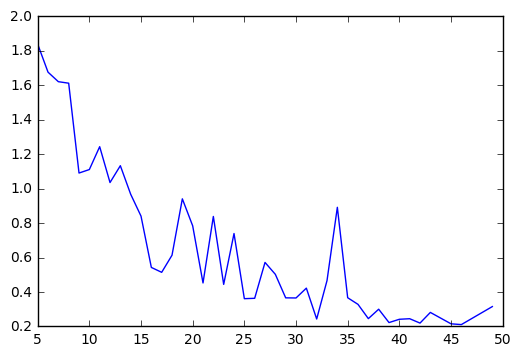

In [161]:
plt.plot(x, y)

In [84]:
m = MarkovChain(raw[:1000], 10)

954


In [85]:
adjm = m.get_adjacency_matrix()

In [86]:
np.sum(adjm, axis=1)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [87]:
S, U = np.linalg.eig(adjm.T)

In [88]:
print(U.T)

[[  5.31330550e-01   4.41271844e-01   9.99199009e-03   1.31479175e-02
    2.66373635e-01   1.78212444e-01   1.64875717e-01   2.35310357e-01
    3.14666078e-01   4.88272469e-01]
 [ -1.36362847e-01  -1.95801303e-01  -5.84788025e-03   9.20295900e-01
   -9.86829862e-03   7.19477706e-03  -8.78117742e-02  -9.92068000e-02
   -1.70585118e-01  -2.22006656e-01]
 [  1.78423425e-01   3.57977082e-01   1.00749752e-02  -3.67272166e-03
   -4.01242241e-01   9.37653405e-02   4.30675698e-01  -3.86756976e-02
   -6.92060200e-01   6.47343394e-02]
 [  2.30857128e-01   2.11657447e-01  -1.46525633e-03  -4.04566328e-03
   -6.36489253e-01   1.28330060e-01   5.42047174e-01   1.13074049e-01
   -2.52035482e-01  -3.31930204e-01]
 [  4.49437832e-01  -1.57946993e-01  -1.15357687e-02  -5.45335517e-03
   -3.62345866e-01   3.84822330e-01  -5.65065880e-01   3.85278237e-01
    3.86344534e-02  -1.55824989e-01]
 [ -1.15989332e-01  -7.00118803e-03  -1.44152795e-03   6.41186579e-04
   -8.57465539e-03   7.04620412e-01  -1.01091

In [89]:
# U is row major
inv_dist = U.T[0]
print(inv_dist)

[ 0.53133055  0.44127184  0.00999199  0.01314792  0.26637364  0.17821244
  0.16487572  0.23531036  0.31466608  0.48827247]


In [90]:
norm_inv_dist = inv_dist / float(sum(inv_dist))

In [91]:
inv2 = sorted(norm_inv_dist)

In [92]:
old_norm_inv_dist = sorted(norm_inv_dist)

In [93]:
old_norm_inv_dist

[0.0037799007928733678,
 0.0049737663347102726,
 0.062371344098738728,
 0.067416535703548622,
 0.089016281607378289,
 0.10076730512897364,
 0.11903600259890167,
 0.16693008870984083,
 0.18471010020468359,
 0.20099867482035097]